# Reduced charge state solution

> When Eq. ~1! is expressed in terms of the parallel flows
using Eq. ~19! to eliminate the poloidal flows# and the sums
over the charge states j for species b are carried out, we
obtain a set of three equations ( a = 1,2,3) for each charge
state of each isotope,

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

In [1]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
fs = eq.get_flux_surface(-0.01);

So we take the general equation (25)

$$A^{ai} \cdot \hat{u}^{ai} = \xi_{ai} \Lambda^a (\bar{u}^b) + S^{ai}$$

This means every charge level has

- [x] an $A^{ai}$ 3x3 matrix (28) using
    - [x] script M
    - [x] viscosities $\hat{\mu}_{\alpha\beta}^{ai}$
    - [x] the charge weight $\xi_{ai}$
    - [x] beta coefficients
- [ ] the $\Lambda^a$ term which depends on the isotope only and involves script N and $\hat{u}_\beta^b$, summed over beta and b

In [2]:
from plasmapy.formulary import neoclassical

In [3]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
a = all_species["H"]
i = 1
ai = a[i]
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [4]:
from plasmapy.formulary.neoclassical import ξ

In [5]:
ξ(all_species["H"])

<Quantity [0., 1.]>

In [6]:
i = 1
ξ(a)

<Quantity [0., 1.]>

In [7]:
beta_cx = np.zeros(3)  # TODO
beta_an = np.zeros(3)  # TODO
beta_coeffs = np.diag(beta_cx + beta_an) * u.kg / u.m ** 3 / u.s

<Quantity [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]] kg / (m3 s)>

In [8]:
neoclassical.M_script(a, all_species)

<Quantity [[-1.24272503,  1.55262355, -1.68605372],
           [ 1.55262355,  4.0043251 ,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400786]] kg / (m3 s)>

In [9]:
# Aai = ξ(a)[i] * neoclassical.M_script(a, all_species) - mu_hat(ai) - beta_coeffs

The really key equation seems to be $A^{ai} \cdot \hat{r}^{ai}_m = S^{ai}_m$, where m is the force source (1, 2, 3, pT, E, NBI and we can neglect the latter two for the first approximation);

$S^{ai}_\alpha$ here being just $\xi_{ai} \hat{e}_\alpha$, the charge weight times a unit vector

We can then do a bunch of inversions and get the $\hat{r}_m^{ai}$'s. 

And then, the naive approach would be to combine them via the $\Lambda_i$-weighted linear combination of equation 31 into the whole charge state flow $\hat{u}^{ai}$.

But this still does not seem to be what they do. Instead they multiply (31) by $\xi_{ai}$ and sum those over the charge states. This basically replaces the $(ai)$ species indices with $a$ isotope indices.

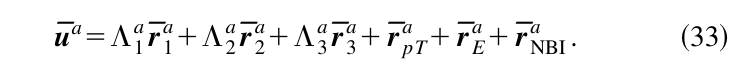

Then they go back to 27

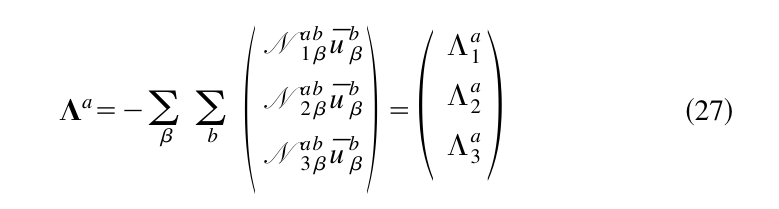

Essentially to back-substitute the $\Lambda^a_i$s, and they get "a linear set of 3n equations for three parallel flow components for the n isotopes",

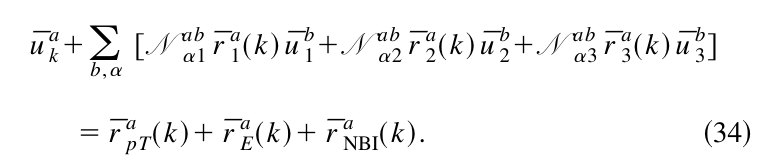

**This** is the equation that gets solved, and the one to tackle the ingredients of next.

In [10]:
from plasmapy.formulary.neoclassical import rbar

rbar(a, all_species, fs)

<Quantity [[-1.05462304,  0.08800967,  0.28232163],
           [ 0.08800967,  0.14085007,  0.06490316],
           [ 0.28232163,  0.06490316, -0.14762642]] m3 s / kg>

In [11]:
rbar(all_species["C"], all_species, fs)

<Quantity [[-0.14694517,  0.01211718,  0.01651547],
           [ 0.01211718,  0.02566462,  0.01224836],
           [ 0.01651547,  0.01224836, -0.02038971]] m3 s / kg>

## The matrix equation solution; all the indices

Okay, this is something stupid. They use

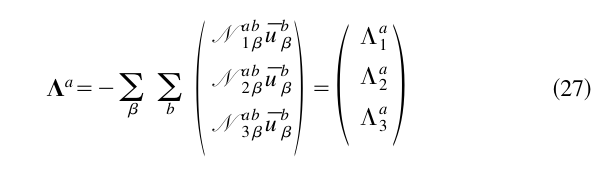

The inner parenthesis has 3 components. Its indices are $(\alpha = [1, 2, 3], \beta, a, b)$

This corresponds to a 4D ndarray.

I'm not yet sure why $\beta$ is there on different "rights" thatn $\alpha$. I guess its column vector status and 

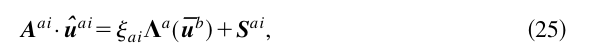

signifies that it's supposed to be a column-row product?

Anyway, let's think about this. We take $N_{\alpha,\beta}^{ab} \bar{u}_\beta^b$. Purely index notation for now and we'll worry about the minus sign later. This is a 4d matrix where, along axes 2 and 4, $\bar{u}$ is applied. Okay.

Summing along $\beta, b$, we reduce this from a 4D (3, 3, N, N) matrix to a 2D (3, N) matrix. Cool. So this does have 3 rows, as shown in eq 27 above.

Thus, $\mathbf{\Lambda}^a$.shape $= (3, N) \implies \mathbf{\Lambda}^a = \Lambda_\gamma^a$.

Note that given we don't yet know $\bar{u}_\beta^b$, we cannot actually compute this just yet. That's what we're going to solve for.

Onwards.

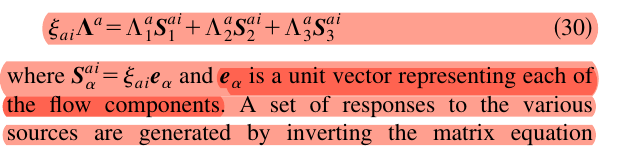

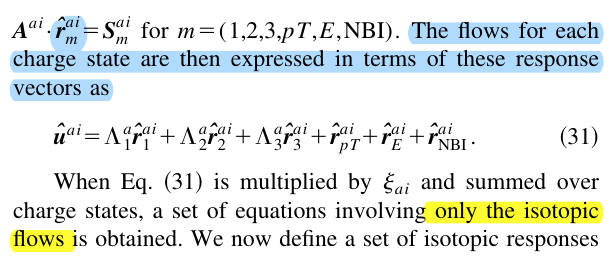

Take the "matrix equation" now. $\mathbf{A}^{ai}$ was defined earlier as

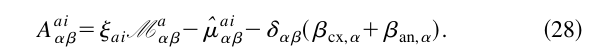

and

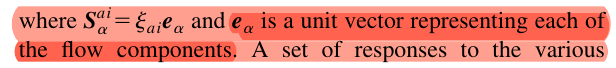

So the matrix equation

$$\mathbf{A}^{ai} \cdot \hat{r}_m^{ai} = \mathbf{S}_m^{ai}$$

is in fact a, for each charge state $ai$, a $(3, 3) \cdot (3,) = (3,)$ matrix equation.

Given that $m = (1, 2, 3, pT, E, NBI), [m] = 6$, that could be recast into a $(3, 3) \cdot (3, 6) = (3, 6)$ matrix equation. In theory. Is that correct?

In [12]:
Amatrix = np.random.random((3, 3))
Smatrix = np.random.random((3, 6))
np.linalg.solve(Amatrix, Smatrix).shape

(3, 6)

Yup! But that would require us to write $r_{\gamma,m}^{ai}$ and $S_{\gamma, m}^{ai}$. Where I chose $\gamma$ to not collide with any existing moment order indices. Awesome.

Then equation 31 can be recast into a matrix product if we were to take a helper matrix $I_6$ (6-dim or m-dim identity) where the upper half is multiplied by $\mathbf{\Lambda}^a$... TODO

But let's skip that for now and carry on. Let's rewrite 32...

$$\bar{r}_{\gamma, m}^a \equiv \Sigma_i \xi_{ai} \hat{r}_{\gamma, m}^{ai}$$

Still a (3, 6) array; and the superscript seems to imply it's going to be a (3, 6, N) array, where N is the number of isotopes in the system. This is a weird non-line

sparse

holy shit, this is a use case for sparse matrices

because the number of charge states varies between different isotopes, right? Hydrogen has basically one, two when accounting for neutrals. Tungsten, though...

[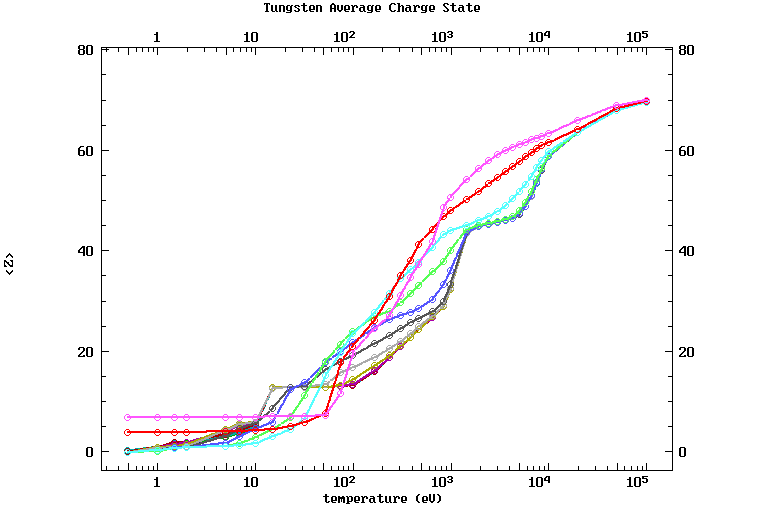](https://www-nds.iaea.org/exfor/servlet/X4sZvd?file=https://www-amdis.iaea.org/FLYCHK/ZBAR/zp074.zvd)

Tungsten goes to like 80 or so. Okay. So we could imagine taking max(number of charge states in the system) = M and allocating this huge array of shape (3, 6, N, M). Well, that's a boatload of zeros, right? Sure. But if this were to be a sparse array, well... that solves both the memory problem of allocating a boatload of zeros, and the speed problem by just not taking the zeros into account.

Huh.

Huuuuuuh.

Something to think about. Still, (32) sidesteps this by essentially collapsing our sparse (3, 6, N, M) array into a dense (3, 6, N) array.

(33) does exactly the thing I thought of above in 31. The shape on this thing is (3, 6, N), still. Right? I mean it has to be, no? 3 moment orders, 6 sources of flow, N isotopes. Yeah, that sounds about right. And the trick with the block `[[Lambda * eye(3)], 0], [0, eye(3)]]` array still should apply. Okayo.

Well, now they combine (27) with (33). This means, in our (3, 6, N) matrix equation, TODO

I honestly think I need to disregard their way of writing (34) and write it myself, with my own notation, from scratch. Let's do that, tbh.

$$\bar{u}_k^a = \Lambda_1^a \bar{r}_{k, 1}^a + \Lambda_2^a \bar{r}_{k, 2}^a + \Lambda_3^a \bar{r}_{k, 3}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

$$\bar{u}_k^a = \Lambda_\alpha^a \bar{r}_{k, \alpha}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

$$\bar{u}_k^a = -N^{ab}_{\alpha\beta} \bar{u}^b_\beta \bar{r}_{k, \alpha}^a + \bar{r}_{k,pT}^a + \bar{r}_{k,E}^a + \bar{r}_{k, NBI}^a$$

| Quantity               | Shape   | Notes                                  |
|------------------------|---------|----------------------------------------|
| $\bar{u}_\gamma^a$     | 3, N    |we solve for this!                      |
| $\bar{r}_{\gamma,m}^a$ | 3, 6, N |all responses, +rhs                     |
| $\Lambda_\gamma^a$     | 3, N    |$-N^{ab}_{\gamma \beta} \bar{u}_\beta^b$; contraction of (3, 3, N, N) with (1, 3, 1, N)|

Now we use (with the summation convention)

$$\Lambda^a_\gamma = -N^{ab}_{\gamma \beta} \bar{u}_\beta^b$$

Subsitute:

$$\bar{u}_\gamma^a = -\sum_{m=(1,2,3)} N_{\gamma\beta}^{ab}\bar{u}_\beta^b \bar{r}_{\gamma, m}^a + \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$\bar{u}_\gamma^a = - \sum_{b,\beta} N_{\gamma\beta}^{ab}\bar{u}_\beta^b \bar{r}_{\gamma, \beta}^a + \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$\bar{u}_\gamma^a +\sum_{b,\beta}N_{\gamma\beta}^{ab} \bar{r}_{\gamma, \beta}^a \bar{u}_\beta^b = \sum_{m=(pT, E, \text{NBI})} \bar{r}_{\gamma, m}^a$$

$$(3, N) + (3, 3, N, N) \otimes (3, 3, N) = (3, N)$$

In [13]:
from plasmapy.formulary.neoclassical import *

In [14]:
lista = [[(a, b) for b in all_species] for a in all_species]

[[(<IonizationState instance for H>, <IonizationState instance for H>),
  (<IonizationState instance for H>, <IonizationState instance for C>)],
 [(<IonizationState instance for C>, <IonizationState instance for H>),
  (<IonizationState instance for C>, <IonizationState instance for C>)]]

In [15]:
len_all_species = 2  # TODO

2

In [16]:
output_matrix = eq34matrix(all_species, fs)

<Quantity [[ 0.80012818, -0.01903646,  0.09487049, -1.25145317,
             0.02483682,  0.03945478],
           [ 0.01667956,  0.96953418,  0.02180986,  0.1044354 ,
             0.03974867,  0.00907029],
           [ 0.0535055 , -0.01403853,  0.95039207,  0.33501287,
             0.01831603, -0.02063096],
           [-0.11230445, -0.0189168 ,  0.01238732,  0.38058884,
            -0.05829437,  0.1234376 ],
           [ 0.00926068, -0.04006648,  0.0091868 ,  0.05107697,
             0.8765304 ,  0.0915449 ],
           [ 0.01262213, -0.01912159, -0.01529317,  0.06961691,
            -0.05892545,  0.84760616]]>

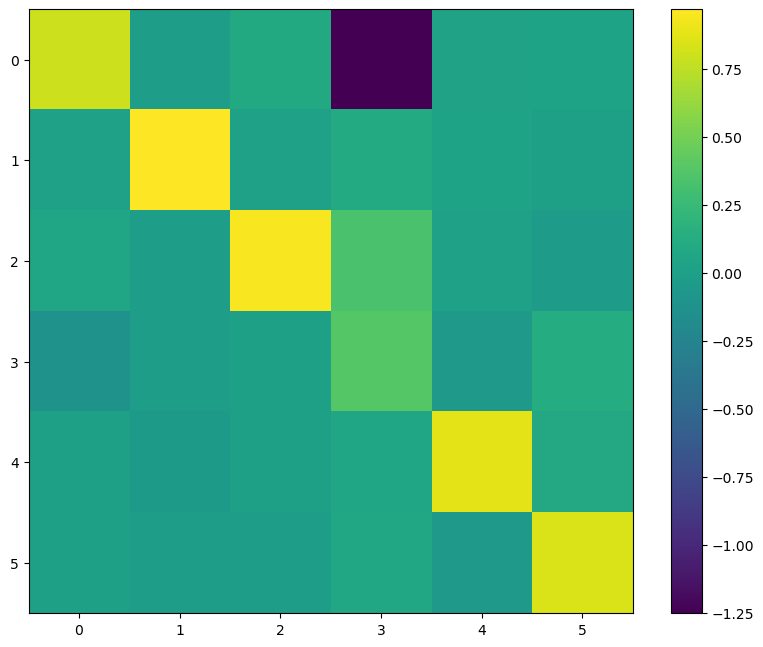

In [17]:
plt.imshow(output_matrix)
plt.colorbar()

## Source terms

TODO add temperatures field to IonizationState rather than T_i argument
TODO Fhat definition may need psi' correction; this would be proportional to flux of B through a bit of surface at that radius.

In [18]:
from astropy import constants

In [19]:
ai.ion.charge

<<class 'astropy.constants.codata2018.EMCODATA2018'> name='Electron charge' value=1.602176634e-19 uncertainty=0.0 unit='C' reference='CODATA 2018'>

In [21]:
# S_pt_1 = Eq21a = fs.Fhat * pressure_gradient / (a.integer_charges * a.number_densities)
# S_pt_2 = Eq21b = fs.Fhat * constants.k_B * temperature_gradient / a.integer_charges

# electric_potential_gradient = 1 * u.V / u.m

# S_er = fs.Fhat * electric_potential_gradient

# effective_pressure_gradient = a.integer_charges * a.number_densities * electric_potential_gradient


# S_pt_1_effective = fs.Fhat * effective_pressure_gradient / (a.integer_charges * a.number_densities)

# S_pt = fs.Fhat / a.integer_charges / a.number_densities

# μ = mu_hat(i, a, all_species, fs)

# # S_pt_ai =
# pressure_gradient[i] * μ[0,0] + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[0,1]

# pressure_gradient[i] * μ[1,0] + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[1,1]

# Spt = (fs.Fhat / ai.integer_charge / ai.number_density * u.Quantity([pressure_gradient[i] * μ[0,0] + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[0,1],
#                                                                      pressure_gradient[i] * μ[1,0] + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[1,1]])).si


def rbar_sources(a, all_species, flux_surface, beta_coeffs=None) -> u.Quantity:
    fs = flux_surface
    if beta_coeffs is not None:
        # TODO should be a dict or sth
        raise NotImplementedError
    else:
        beta_cx = np.zeros(3)  # TODO
        beta_an = np.zeros(3)  # TODO
        beta_coeffs = np.diag(beta_cx + beta_an) * u.kg / u.m ** 3 / u.s
    pressures = (a.number_densities * constants.k_B * a.T_e).to(u.Pa)

    num_charge_states = len(a.integer_charges)
    temperatures = u.Quantity([a.T_e] * num_charge_states)

    # TODO make these inputs
    density_gradient = u.Quantity(num_charge_states * [1e18 * u.m ** -3 / u.m])
    temperature_gradient = u.Quantity(num_charge_states * [10 * u.K / u.m])

    # but not this, this is dervied
    pressure_gradient = constants.k_B * (
        temperatures * density_gradient + a.number_densities * temperature_gradient
    )

    def gen():
        for i, ai in enumerate(a):
            if ξ(a)[i] == 0:
                continue  # won't add anything to sum anyway, and matrix gets singular
            Aai = (
                ξ(a)[i] * M_script(a, all_species)
                - mu_hat(i, a, all_species, flux_surface)
                - beta_coeffs
            )
            μ = mu_hat(i, a, all_species, fs)
            Spt = (
                fs.Fhat
                / ai.ion.charge
                / ai.number_density
                * u.Quantity(
                    [
                        pressure_gradient[i] * μ[0, 0]
                        + a.number_densities[i]
                        * constants.k_B
                        * temperature_gradient[i]
                        * μ[0, 1],
                        pressure_gradient[i] * μ[1, 0]
                        + a.number_densities[i]
                        * constants.k_B
                        * temperature_gradient[i]
                        * μ[1, 1],
                    ]
                )
            ).si
            Spt = np.append(Spt, 0)
            S_matrix = Spt
            rai_as_rows = np.linalg.solve(Aai, S_matrix)
            # TODO does not include r_pT, r_E, r_NBI yet
            rbar_ingredient = ξ(a)[i] * rai_as_rows
            yield rbar_ingredient

    return sum(gen())


rbar_sources(a, all_species, fs)

<Quantity [-0.15595747, -0.01338926,  0.025988  ] J2 s / (A kg m3)>

In [22]:
original_rhs = np.concatenate([rbar(a, all_species, fs) for a in all_species])
original_rhs

<Quantity [[-1.05462304,  0.08800967,  0.28232163],
           [ 0.08800967,  0.14085007,  0.06490316],
           [ 0.28232163,  0.06490316, -0.14762642],
           [-0.14694517,  0.01211718,  0.01651547],
           [ 0.01211718,  0.02566462,  0.01224836],
           [ 0.01651547,  0.01224836, -0.02038971]] m3 s / kg>

In [23]:
rhs = np.concatenate([rbar_sources(a, all_species, fs) for a in all_species]).si
rhs

<Quantity [-0.15595747, -0.01338926,  0.025988  , -0.0273819 ,  0.00165054,
            0.00276748] V / m>

In [24]:
lhs = eq34matrix(all_species, fs)
lhs

<Quantity [[ 0.80012818, -0.01903646,  0.09487049, -1.25145317,
             0.02483682,  0.03945478],
           [ 0.01667956,  0.96953418,  0.02180986,  0.1044354 ,
             0.03974867,  0.00907029],
           [ 0.0535055 , -0.01403853,  0.95039207,  0.33501287,
             0.01831603, -0.02063096],
           [-0.11230445, -0.0189168 ,  0.01238732,  0.38058884,
            -0.05829437,  0.1234376 ],
           [ 0.00926068, -0.04006648,  0.0091868 ,  0.05107697,
             0.8765304 ,  0.0915449 ],
           [ 0.01262213, -0.01912159, -0.01529317,  0.06961691,
            -0.05892545,  0.84760616]]>

In [25]:
ubar = np.linalg.solve(lhs, rhs)
ubar

<Quantity [-0.65237041,  0.02256633,  0.16316816, -0.2787691 ,  0.02008778,
            0.04072572] V / m>

And then they get the flows for each charge state using

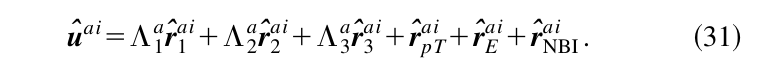

And now we use equation 31 to get $u^{ai}$ back from $\bar{u}$. Oh shit, that uses the per isotope responses. Crap. How do we do that, then?

Well, we can now pretty much directly...

In [26]:
Λs = []
for I, a in enumerate(all_species):

    def gen():
        i = 3 * I
        for J, b in enumerate(all_species):
            j = 3 * J
            ubar_b = ubar[j : j + 3]
            yield (N_script(a, b) * ubar_b.reshape(1, -1)).sum(axis=1)

    Λs.append(-sum(gen()))


Λs

[<Quantity [ 0.43107543, -0.44750103,  0.40955016] kg V / (m4 s)>,
 <Quantity [ 1.97263447, -0.95000427,  0.35613348] kg V / (m4 s)>]

In [27]:
b = all_species["C"]

<IonizationState instance for C>

In [28]:
N_script(a, b)

<Quantity [[  5.86470052,  -4.39852539,   2.74907837],
           [ -4.39852539,   9.89668213, -10.30904389],
           [  2.74907837, -10.30904389,  15.03402234]] kg / (m3 s)>

In [29]:
(ubar[:3] * N_script(a, b)).si

<Quantity [[-3.8259571 , -0.09925856,  0.44856207],
           [ 2.86946782,  0.22333176, -1.68210775],
           [-1.79341739, -0.23263725,  2.4530738 ]] J2 / (A m6)>

In [30]:
for (I, (a, Λ)) in enumerate(zip(all_species, Λs)):
    print(I, a, Λ)

0 <IonizationState instance for H> [ 0.43107543 -0.44750103  0.40955016] kg V / (m4 s)
1 <IonizationState instance for C> [ 1.97263447 -0.95000427  0.35613348] kg V / (m4 s)


In [31]:
a = all_species["H"]

<IonizationState instance for H>

In [32]:
ξ(a)

<Quantity [0., 1.]>

In [33]:
Λ = Λs[0]

<Quantity [ 0.43107543, -0.44750103,  0.40955016] kg V / (m4 s)>

In [34]:
Aai = ξ(a)[i] * M_script(a, all_species) - mu_hat(i, a, all_species, fs) - beta_coeffs

<Quantity [[-1.28143607,  1.60482396, -1.74507365],
           [ 1.60482396,  3.89390847,  4.7810107 ],
           [-1.74507365,  4.7810107 , -8.00919883]] kg / (m3 s)>

In [35]:
S_ai = ξ(a)[i] * np.eye(3) * Λ.reshape(1, -1)

<Quantity [[ 0.43107543, -0.        ,  0.        ],
           [ 0.        , -0.44750103,  0.        ],
           [ 0.        , -0.        ,  0.40955016]] kg V / (m4 s)>

In [36]:
rai_as_rows = np.linalg.solve(Aai, S_ai)

<Quantity [[-0.45462208, -0.03938442,  0.11562487],
           [ 0.03793881, -0.06303055,  0.0265811 ],
           [ 0.12170192, -0.02904423, -0.06046042]] V / m>

In [37]:
pressures = (a.number_densities * constants.k_B * a.T_e).to(u.Pa)

num_charge_states = len(a.integer_charges)
temperatures = u.Quantity([a.T_e] * num_charge_states)

# TODO make these inputs
density_gradient = u.Quantity(num_charge_states * [1e18 * u.m ** -3 / u.m])
temperature_gradient = u.Quantity(num_charge_states * [10 * u.K / u.m])

# but not this, this is dervied
pressure_gradient = constants.k_B * (
    temperatures * density_gradient + a.number_densities * temperature_gradient
)
μ = mu_hat(i, a, all_species, fs)
Spt = (
    fs.Fhat
    / ai.ion.charge
    / ai.number_density
    * u.Quantity(
        [
            pressure_gradient[i] * μ[0, 0]
            + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[0, 1],
            pressure_gradient[i] * μ[1, 0]
            + a.number_densities[i] * constants.k_B * temperature_gradient[i] * μ[1, 1],
        ]
    )
).si
Spt = np.append(Spt, 0)

<Quantity [ 0.13301115, -0.17817193,  0.        ] J2 / (A m6)>

In [38]:
actual_unit_of_μ = (Spt.unit * u.C * (1 / u.m ** 3) / (u.Pa / u.m)).si
actual_unit_of_μ

<Quantity 1. kg / (m3 s)>

In [39]:
μ.unit

Unit("kg / (m3 s)")

In [40]:
Aai.unit

Unit("kg / (m3 s)")

In [41]:
(u.Pa * u.s / μ.unit).si

Unit("m2")

In [42]:
intended_unit_of_μ = ((u.V / u.m) * u.C * (1 / u.m ** 3) / (u.Pa / u.m)).si
intended_unit_of_μ

<Quantity 1.>

In [43]:
actual_unit_of_μ / intended_unit_of_μ

<Quantity 1. kg / (m3 s)>

In [44]:
neoclassical._integrand(1, 1, 1, 1, a, all_species, fs)

<Quantity [130686.08742149] 1 / s>

In [45]:
rai_as_rows

<Quantity [[-0.45462208, -0.03938442,  0.11562487],
           [ 0.03793881, -0.06303055,  0.0265811 ],
           [ 0.12170192, -0.02904423, -0.06046042]] V / m>

In [46]:
order_flow_sum = (Λ.reshape(-1, 1) * rai_as_rows).sum(axis=0).si.value  # TODO fix units

array([-0.16311102, -0.00066649,  0.01318639])

In [47]:
Aai

<Quantity [[-1.28143607,  1.60482396, -1.74507365],
           [ 1.60482396,  3.89390847,  4.7810107 ],
           [-1.74507365,  4.7810107 , -8.00919883]] kg / (m3 s)>

In [48]:
rpt_row = np.linalg.solve(Aai, Spt).si.value

array([-0.15595747, -0.01338926,  0.025988  ])

In [50]:
flows = order_flow_sum + rpt_row  # Eq31

array([-0.3190685 , -0.01405575,  0.0391744 ])

In [53]:
def get_flows():
    original_rhs = np.concatenate([rbar(a, all_species, fs) for a in all_species])
    rhs = np.concatenate([rbar_sources(a, all_species, fs) for a in all_species]).si
    lhs = eq34matrix(all_species, fs)
    ubar = np.linalg.solve(lhs, rhs)

    # use Eq31 to get charge state flows from isotopic flows
    Λs = []
    for I, a in enumerate(all_species):

        def gen():
            i = 3 * I
            for J, b in enumerate(all_species):
                j = 3 * J
                ubar_b = ubar[j : j + 3]
                yield (N_script(a, b) * ubar_b.reshape(1, -1)).sum(axis=1)

        Λs.append(-sum(gen()))
    Aai = (
        ξ(a)[i] * M_script(a, all_species) - mu_hat(i, a, all_species, fs) - beta_coeffs
    )
    Λ = Λs[0]  # TODO double check this indexing
    S_ai = ξ(a)[i] * np.eye(3) * Λ.reshape(1, -1)
    rai_as_rows = np.linalg.solve(Aai, S_ai)

    pressures = (a.number_densities * constants.k_B * a.T_e).to(u.Pa)

    num_charge_states = len(a.integer_charges)
    temperatures = u.Quantity([a.T_e] * num_charge_states)

    # TODO make these inputs
    density_gradient = u.Quantity(num_charge_states * [1e18 * u.m ** -3 / u.m])
    temperature_gradient = u.Quantity(num_charge_states * [10 * u.K / u.m])

    # but not this, this is dervied
    pressure_gradient = constants.k_B * (
        temperatures * density_gradient + a.number_densities * temperature_gradient
    )
    μ = mu_hat(i, a, all_species, fs)
    Spt = (
        fs.Fhat
        / ai.ion.charge
        / ai.number_density
        * u.Quantity(
            [
                pressure_gradient[i] * μ[0, 0]
                + a.number_densities[i]
                * constants.k_B
                * temperature_gradient[i]
                * μ[0, 1],
                pressure_gradient[i] * μ[1, 0]
                + a.number_densities[i]
                * constants.k_B
                * temperature_gradient[i]
                * μ[1, 1],
            ]
        )
    ).si
    Spt = np.append(Spt, 0)
    order_flow_sum = (
        (Λ.reshape(-1, 1) * rai_as_rows).sum(axis=0).si.value
    )  # TODO fix units
    rpt_row = np.linalg.solve(Aai, Spt).si.value
    flows = order_flow_sum + rpt_row  # Eq31
    return flows


get_flows()

/usr/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


array([nan, nan, nan])

# Particle and heat fluxes

In [52]:
a = all_species["C"]  # TODO verfiy!!!

<IonizationState instance for C>

In [53]:
i = 6
ai = a[i]

IonicLevel('C 6+', ionic_fraction=1.0)

In [54]:
u_velocity = rpt_row  # TODO replace with full form once units are okay

<Quantity [-0.15597208, -0.01339055,  0.02599044] V / m>

In [55]:
def thermodynamic_forces(
    a, density_gradient=1e18 * u.m ** -3 / u.m, temperature_gradient=10 * u.K / u.m,
):
    num_charge_states = len(a.integer_charges)
    temperatures = u.Quantity([a.T_e] * num_charge_states)

    density_gradient = u.Quantity(num_charge_states * [density_gradient])
    temperature_gradient = u.Quantity(num_charge_states * [temperature_gradient])

    # but not this, this is dervied
    pressure_gradient = constants.k_B * (
        temperatures * density_gradient + a.number_densities * temperature_gradient
    )

    for i in range(num_charge_states):
        μ = mu_hat(i, a, all_species, fs)
        thermodynamic_forces = u.Quantity(
            [
                fs.Fhat / ai.ion.charge / ai.number_density * pressure_gradient[i],
                fs.Fhat / ai.ion.charge * constants.k_B * temperature_gradient[i],
            ]
        )

        thermodynamic_forces = np.append(thermodynamic_forces, 0)
        yield thermodynamic_forces


list(thermodynamic_forces(a))

/usr/lib/python3.9/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[<Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.17989491e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>,
 <Quantity [7.18484464e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>]

In [56]:
td_forces = list(thermodynamic_forces(a))[i]

<Quantity [7.18484464e+00, 4.94972378e-03, 0.00000000e+00] J / (C m)>

TODO flux surface average drops units...

In [57]:
B2fsav = fs.flux_surface_average(fs.B2) * u.T ** 2  # flux surface averaged B^2

<Quantity 34.48007017 T2>

In [58]:
u_θ = (u_velocity + td_forces) / B2fsav

<Quantity [ 0.2038532 , -0.0002448 ,  0.00075378] V / (m T2)>

In [59]:
Γ_BP = -(fs.Fhat / ai.ion.charge * (μ[0, :] * u_θ).sum()).si

<Quantity -2.84991502e+17 1 / (m2 s)>

In [60]:
(μ[1, :] * u_θ).si

<Quantity [-1.06422415e-02, -2.70329168e-05, -1.01160651e-04] A / m2>

In [61]:
(fs.Fhat * constants.k_B * temperatures[i] / ai.ion.charge)

IndexError: index 6 is out of bounds for axis 0 with size 2

In [ ]:
# TODO verify unit; does not look right
q_BP = -(
    fs.Fhat * constants.k_B * temperatures[i] / ai.ion.charge * (μ[1, :] * u_θ).sum()
).si

In [ ]:
Binv2fsav = fs.flux_surface_average(1 / fs.B2) / u.T ** 2
Γ_PS = -fs.Fhat / ai.ion.charge * ξ(a)[i] / B2fsav * (1 - B2fsav * Binv2fsav)

In [ ]:
np.array(list(thermodynamic_forces(a)))

In [ ]:
((u.Pa * u.T / u.m) / (u.kg / u.m ** 3 / u.s)).si

In [ ]:
sum(
    (ξ(b)[:, np.newaxis] * np.array(list(thermodynamic_forces(b)))).sum(axis=0)
    * N_script(a, b)[0]
    for b in all_species
) + (M_script(a, all_species)[0, :] * list(thermodynamic_forces(a))[i]).si

In [ ]:
sum(thermodynamic_forces(a))

In [ ]:
Out[260] + Out[258]

In [ ]:
[ξ(b) * N]

In [ ]:
def gen():
    for b in all_species:
        pressures = (b.number_densities * constants.k_B * b.T_e).to(u.Pa)

        num_charge_states = len(b.integer_charges)
        temperatures = u.Quantity([b.T_e] * num_charge_states)

        # TODO make these inputs
        density_gradient = u.Quantity(num_charge_states * [1e18 * u.m ** -3 / u.m])
        temperature_gradient = u.Quantity(num_charge_states * [10 * u.K / u.m])

        # but not this, this is dervied
        pressure_gradient = constants.k_B * (
            temperatures * density_gradient + b.number_densities * temperature_gradient
        )

        μ = mu_hat(i, a, all_species, fs)
        thermodynamic_forces = u.Quantity(
            [
                fs.Fhat / ai.ion.charge / ai.number_density * pressure_gradient[i],
                fs.Fhat / ai.ion.charge * constants.k_B * temperature_gradient[i],
            ]
        )

        thermodynamic_forces = np.append(thermodynamic_forces, 0)
        yield ξ(b) * N_script(a, all_species)[0, :] * thermodynamic_forces

In [ ]:
# -fs.Fhat / ai.ion.charge *

## Local flow velocities

In [ ]:
fs.Bt = fs.Bphivals

Eq45a = fs.Bp
Eq45b = fs.Bt * 1 - 1 / fs.Bt
Eq45c = fs.Bmag * 1 - 1 / fs.Bmag
Eq45d = fs.Bp / fs.Bmag / fs.Bt
plt.plot(fs.lp, Eq45a)
plt.plot(fs.lp, Eq45b)
plt.plot(fs.lp, Eq45c)
plt.plot(fs.lp, Eq45d)

# Diffusion coefficients

In [ ]:
Γ = Γ_BP  # TODO PLACEHOLDER

In [ ]:
a.number_densities

In [ ]:
temperature_gradient

In [ ]:
a.number_densities

In [ ]:
temperature_gradient

In [ ]:
D_C_T_e = -Γ / a.number_densities / (temperature_gradient / a.T_e)

In [ ]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

In [ ]:
from plasmaboundaries import NSTX_double_null

NSTX_double_null

In [ ]:
NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA

In [ ]:
def get_derivatives():

    from sympy.abc import C, D, x

    T = C * (1 - x ** 2) + D
    n_e = C * (1 - x ** 2) ** 0.5 + D
    return T.diff(x).simplify(), n_e.diff(x).simplify()


get_derivatives()

In [ ]:
ρ_normed = np.linspace(0, 1, 100)
T0_min = 0.5 * u.keV
T0_max = 2 * u.keV
n_D0 = 6.5e19 * u.m ** -3
n_C = 5e18 * u.m ** -3

T0 = T0_max  # they scan, but I don't bother for now
Ta = 0.05 * T0
T = (T0 - Ta) * (1 - ρ_normed ** 2) + Ta
Tprime = -2 * (T0 - Ta) * ρ_normed / u.m
plt.plot(ρ_normed, T)
plt.plot(ρ_normed, Tprime)

plt.figure()
ne0 = n_D0  # TODO double check
nea = 0.3 * ne0
n_e = (ne0 - nea) * (1 - ρ_normed ** 2) ** 0.5 + nea
n_e_prime = (-(ne0 - nea) * ρ_normed * (1 - ρ_normed ** 2) ** -0.5) / u.m
plt.plot(ρ_normed, n_e)
plt.plot(ρ_normed, n_e_prime)

In [ ]:
index_middle = 50
D_C_T_e = -Γ / n_e[index_middle] / (Tprime[index_middle] / T[index_middle])